In [ ]:
!pip install -q langchain langgraph transformers bitsandbytes langchain-huggingface langchain-community chromadb openai

# Agent Tool簡介

在 LangChain 架構中，Agent 是一種具備「決策能力」的 LLM 應用，可以根據輸入動態決定接下來要採取的動作。
Tools 則是 Agent 能夠使用的「功能元件」，讓它得以執行超出純語言生成的任務，例如查資料、運算、搜尋等等。

這樣的設計使得 LLM 不僅能回答問題，還能「實際做事」。



---


## 常見 Tool 類型
LangChain 支援各種內建或自定義的 Tools，例如：
- Search Tool：連結網路搜尋引擎，查找即時資訊。
- Calculator Tool：執行基本運算或進階數學計算。
- Database Query Tool：查詢向量資料庫、SQL 等結構化資料來源。
- Document Retriever：從知識庫中檢索相關段落，用於 RAG 應用。
- Custom Tool：開發者可自訂任意 Python 函式或 API 作為工具，給 Agent 使用。


---


## 如何使用 Tool
1. **格式化輸出 → 自行呼叫工具（LLM as planner）**
2. **直接由 Agent 呼叫工具（LLM as agent）**

## 格式化輸出 → 自行呼叫工具（LLM as planner）
這種方式是讓 LLM 扮演「規劃者」的角色，只<u>**負責產生要執行的動作與參數**</u>，而不實際執行。例如，我們會引導模型輸出像這樣的格式：

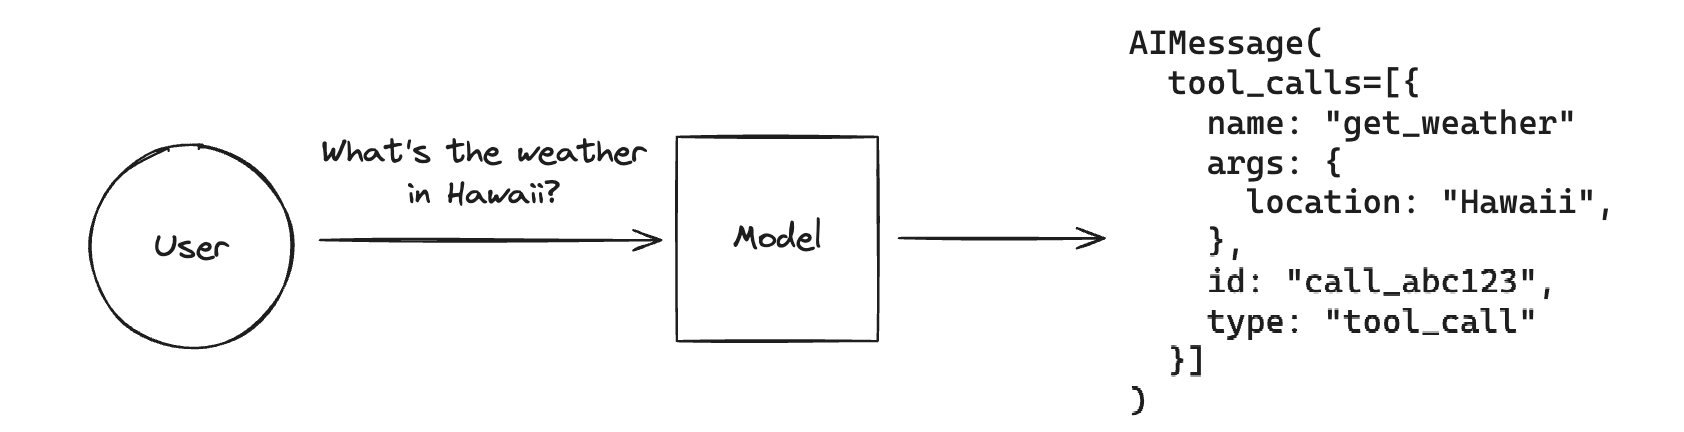

### 載入模型

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from langchain_huggingface import HuggingFacePipeline

# 使用 4-bit 量化模型
model_id = "MediaTek-Research/Breeze-7B-Instruct-v1_0"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_threshold=6.0,
)

# 載入 tokenizer 與 4-bit 模型
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quant_config,
    trust_remote_code=True
)

In [3]:
# 建立 text generation pipeline
generator = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.4,
    return_full_text=False # 僅返回生成的回應內容
)

# 包裝成 LangChain 的 llm 物件
llm = HuggingFacePipeline(pipeline=generator)

Device set to use cuda:0


### 📌 使用In-Context Learning 達成格式化輸出



---


**In-Context Learning（上下文學習）** 是大型語言模型（LLM）最具代表性的能力之一。

它的核心概念是：

> **不需要微調模型，只要在提示中提供幾個範例，模型就能「學會」模仿這種格式並產出對應結果。**

這種能力讓我們可以用簡單的 **提示工程（prompt engineering）** 方式，快速讓模型執行結構化任務，例如：
- 摘要撰寫
- 資訊萃取
- 格式轉換（如輸出成 JSON）
- 對話模仿、邏輯推理等

### ✨ 優點：
- 無需訓練或更新模型權重
- 快速實驗、多任務切換靈活
- 非常適合少量樣本（few-shot）場景



In [4]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

In [5]:
import json

In [6]:
template = """
請根據輸入的文字資訊，輸出一個 JSON 格式的摘要。

輸入：馬雲是阿里巴巴的創辦人，也是一位著名的中國企業家。
輸出：
{{
  "name": "馬雲",
  "role": "阿里巴巴創辦人",
  "description": "著名的中國企業家"
}}

輸入：特斯拉由伊隆·馬斯克領導，他同時創辦了 SpaceX 和 Neuralink。
輸出：
{{
  "name": "伊隆·馬斯克",
  "role": "特斯拉領導人",
  "description": "創辦了 SpaceX 和 Neuralink"
}}

輸入：{input}
輸出：
"""

prompt = PromptTemplate.from_template(template)

In [7]:
chain = LLMChain(llm=llm, prompt=prompt)

<ipython-input-7-726db833e4be>:1: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(llm=llm, prompt=prompt)


In [28]:
# 範例
user_input = "台積電是全球最大的晶圓代工廠，魏哲家擔任董事長。"
response = chain.invoke({"input": user_input})
print(json.loads(response['text']))

{'name': '魏哲家', 'role': '台積電董事長', 'description': '全球最大晶圓代工廠'}


## 直接由 Agent 呼叫工具（LLM as agent）
這種方式是讓 LLM 扮演「代理人」的角色，不僅負責判斷要執行什麼動作，還會<u>**直接觸發對應的工具呼叫與執行流程**</u>。

開發者只需提供任務說明，Agent 會完成以下所有步驟：
1. 決定是否需要使用工具
2. 選擇要用的工具（根據 tool name）
3. 生成對應的參數
4. 執行工具並取得結果
5. 根據結果進一步回應使用者

### OpenAI Function Calling


---


OpenAI Function Calling 是一種讓語言模型能夠**主動產生結構化函式**的機制，使模型不只回應文字，還能觸發後端定義的功能。這種方式能讓語言模型與程式邏輯、外部系統（如資料庫、API）緊密整合。


提醒：不是所有模型都支援Tool使用，若遇到不支援的模型，可以換模型或採用In-context learning的做法。



### 使用llm.invoke指定輸出為json format

In [9]:
import datetime
from langchain.agents import initialize_agent, AgentType
from langchain.tools import Tool
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage
from langchain.schema import SystemMessage
import os

In [10]:
from google.colab import userdata
# ✅ 設定 API 金鑰
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [22]:
# ✅ 原始 Python 函式
def get_weather(location: str, date: str = None) -> str:
    if not date:
        date = (datetime.date.today() + datetime.timedelta(days=1)).isoformat()
    return f"{location} 在 {date} 的天氣是晴時多雲，氣溫約 26~32°C。"

# ✅ 包成 LangChain Tool
weather_tool = Tool(
    name="get_weather",
    func=get_weather,
    description="查詢指定地點與日期的天氣。location 是地點，date 是日期（格式：YYYY-MM-DD，可選）"
)

# ✅ 手動定義 tools 給 LLM
functions = [{
    "name": weather_tool.name,
    "description": weather_tool.description,
    "parameters": {
        "type": "object",
        "properties": {
            "location": {"type": "string", "description": "查詢地點"},
            "date": {"type": "string", "description": "查詢的日期，如 2025-05-2"}
        },
        "required": ["location"]
    }
}]
# ✅ 初始化 LLM
llm = ChatOpenAI(model="gpt-4-0613")

# ✅ 準備 system prompt，告訴模型「今天日期」
today_str = datetime.datetime.today().strftime("%Y-%m-%d")

# ✅ 傳送訊息，讓 LLM 規劃工具呼叫（但不執行）
response = llm.invoke(
    input = [
        SystemMessage(content=f"今天是 {today_str}，請根據這個日期解讀使用者輸入的時間詞。"),
        HumanMessage(content="我想知道後天台北的天氣")
    ],
    functions=functions,
    function_call="auto"
)

# ✅ 顯示結果
if response.additional_kwargs.get("function_call"):
    func_call = response.additional_kwargs["function_call"]
    print("📌 Function Name:", func_call["name"])
    print("📦 Arguments (JSON):", func_call["arguments"])
else:
    print("❌ 模型沒有產生 function_call。")

📌 Function Name: get_weather
📦 Arguments (JSON): {
  "location": "台北",
  "date": "2025-05-23"
}


### 讓Agent直接執行Tool，並回傳結果

In [20]:
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent, AgentType
from langchain.tools import tool
import datetime

# 1️⃣ 以 @tool 定義可被 Agent 呼叫的函式
@tool
def get_weather(location: str, date: str = None) -> str:
    """查詢指定地點與日期的天氣。location 是地點，date 是日期（YYYY-MM-DD，可選）"""
    if not date:
        date = (datetime.date.today() + datetime.timedelta(days=1)).isoformat()
    return f"{location} 在 {date} 的天氣是晴時多雲，氣溫約 26~32 °C。"

# 2️⃣ 建立 LLM
llm = ChatOpenAI(model="gpt-4-0613")

# 3️⃣ 準備 system prompt，告訴模型「今天日期」
today_str = datetime.date.today().isoformat()
system_prompt = (
    f"今天日期是 {today_str}。在理解使用者提到的『今天、明天、後天』等相對日期時，"
    "請以此日期為基準並回覆具體的 YYYY-MM-DD。"
)

# 4️⃣ 初始化 Agent，透過 agent_kwargs 傳入 system prompt
agent = initialize_agent(
    tools=[get_weather],
    llm=llm,
    agent=AgentType.OPENAI_FUNCTIONS,
    agent_kwargs={"system_message": system_prompt},
    verbose=True          # 打開詳盡日誌，方便觀察工具呼叫
)

In [21]:
# 5️⃣ 啟動 Agent：模型會用 system prompt 為基準，自動呼叫工具並回覆
response = agent.run("我想知道後天高雄的天氣")
print(response)



> Entering new AgentExecutor chain...

Invoking: `get_weather` with `{'location': '高雄', 'date': '2025-05-23'}`


高雄 在 2025-05-23 的天氣是晴時多雲，氣溫約 26~32 °C。後天（2025-05-23）高雄的天氣預報是晴時多雲，氣溫約在 26 到 32 度之間。

> Finished chain.
後天（2025-05-23）高雄的天氣預報是晴時多雲，氣溫約在 26 到 32 度之間。
